In [1]:
from mGST.utility_functions_comparisons import get_x_from_k, get_full_mgst_parameters_from_configuration
from mGST.algorithm import gd
from mGST.low_level_jit import cost_function_jax_jit
from iqm.benchmarks.compressive_gst.compressive_gst import GSTConfiguration

import jax.numpy as jnp
import jax

backend = "iqmfakeapollo"

%load_ext autoreload
%autoreload 2

In [2]:
def contract_kraus_state_povm(kraus, depth, dim_squared, gate_indices, povm, state):
    """
    Contraction path that creates first a big tensor for the gates and then contracts it with the state and povm.
    
    It is expected that this cost function scales as O((2^N)^8).
    """
    superop = get_x_from_k(k=kraus, d=depth, r=dim_squared)
    full_gates_superop = contract(superop, gate_indices)
    return povm.conj() @ full_gates_superop @ state
    # return jnp.einsum("i,ij,j->", povm.conj(), full_gates_superop, state)

def contract_kraus_state_all_povm(kraus, d, r, gate_indices, povm_tensor, state, prob_tensor):
    """Full contraction using all the POVM's in povm_tensor

    Args:
        kraus: kraus tensor of dimensions: (num_gates, kraus_rank, dim_out, dim_in)
        d: _description_
        r: _description_
        gate_indices: list of lists, where each inner list contains the indices of the gates to be contracted
        povm_tensor: tensor of dimensions (num_povm, dim, dim)
        state: tensor of dimension (dim**2)
        prob_tensor: tensor containing the experimental probabilities, with dimension: (num_povm)
    Returns:
        summed expectation value
    """
    superop = get_x_from_k(k=kraus, d=d, r=r)
    cost_fn_value = 0
    for prob, povm in zip(prob_tensor, povm_tensor):
        full_gates_superop = contract(superop, gate_indices)
        cost_fn_value += abs(povm.conj() @ full_gates_superop @ state - prob)**2
    return cost_fn_value

def contract(X, j_vec):
    """Contract a sequence of matrices in the given order.
    
    Implementation from mGST.low_level_jit without the j_vec processing
    """
    res = jnp.eye(X[0].shape[0])
    res = res.astype(jnp.complex128)
    for j in j_vec:
        # res = jnp.einsum("ij,jk->ik", res, X[j])
        res = res.dot(X[j])
    return res

In [3]:
# Now let's code up the MPS one
def contract_mps_strategy(kraus, dim, gate_indices, povm, state, vectorized:bool=False):
    """
    MPS-like strategy to contract the full chain.
    
    kraus: kraus tensor of dimensions: (num_gates, kraus_rank, dim_out, dim_in)
        dim_out = dim_in = dim
        num_gates: is the number of gates (first dimension in kraus tensor)
    dim: local hilbert space dimension = 2^N
    
    It is expected that this cost function scales as O((2^N)^3 * rank * depth).
    """
    if vectorized:
        return _contract_mps_vectorized(kraus, dim, gate_indices, povm, state)
    
    return _contract_mps_tensors(kraus, gate_indices, povm, state)

def contract_mps_all_povm(kraus, gate_indices, povm_tensor, state, prob_tensor):
    """Compute the full cost function for a single set of gate indices.

    Args:
        kraus: tensor of dimensions: (num_gates, kraus_rank, dim_out, dim_in)
        gate_indices: list of indices that dictate which k[idx] will be chosen for each contraction loop.
        povm_tensor: tensor containing all povm of dimensions: (num_povm, dim, dim)
        state: tensor of dimensions: (dim, dim)
        prob_tensor: tensor of dimension: (num_povm)
    """
    # Initialize right tensor as the state
    right_tensor = state  # dim_up_in, dim_down_in
    # Iterate through the Kraus tensors in reverse order
    for idx in reversed(gate_indices):
        k = kraus[idx]  # kraus_rank, dim_up_out, dim_up_in
        # (kraus_rank, dim_up_out, dim_up_in) x (dim_up_in, dim_down_in) -> kraus_rank, dim_up_out, dim_down_in
        right_tensor = jnp.einsum("ijk,kl->ijl", k, right_tensor)
        # (kraus_rank, dim_up_out, dim_down_in) x (kraus_rank, dim_down_out, dim_down_in) -> dim_up_in, dim_down_in
        right_tensor = jnp.einsum("ijl,iml->jm", right_tensor, k.conj()) 

    inner_prod = jnp.einsum("kij,ij->k", povm_tensor.conj(), right_tensor) # (num_povm, dim, dim) x (dim, dim) -> num_povm
    cost_vector = jnp.abs(inner_prod - prob_tensor)**2
    return jnp.einsum("i->", cost_vector)
    # return jnp.sum(cost_vector)
        
def _contract_mps_tensors(kraus, gate_indices, povm, state):
    left_tensor = povm.conj() # dim_up_in, dim_down_in
    for idx in gate_indices:
        k = kraus[idx] # kraus_rank, dim_up_out, dim_up_in
        # (kraus_rank, dim_up_out, dim_up_in) x (dim_up_in, dim_down_in) -> kraus_rank, dim_up_in, dim_down_in
        left_tensor = jnp.einsum("ijk,jl->ikl", k, left_tensor)
        # k*: kraus_rank, dim_down_out, dim_down_in
        # (kraus_rank, dim_up_in, dim_down_in) x (kraus_rank, dim_down_out, dim_down_in) ->
        left_tensor = jnp.einsum("ikl,ilm->km", left_tensor, k.conj())
    return jnp.einsum("ij,ij->", left_tensor, state)
    
def _contract_mps_vectorized(kraus, dim, gate_indices, povm, state):
    left_tensor = jnp.reshape(povm.conj(), shape=(dim, dim)) # dim_up_in, dim_down_in
    for idx in gate_indices:
        k = kraus[idx] # kraus_rank, dim_up_out, dim_up_in
        left_tensor = jnp.einsum("ijk,jl->ikl", k, left_tensor)
        left_tensor = jnp.einsum("ikl,ilm->km", left_tensor, k.conj())
        
    left_vector = jnp.reshape(left_tensor, shape=(dim**2))
    return jnp.einsum("i,i->",left_vector, state)

def _contract_mps_tensors_tensordot(kraus, gate_indices, povm, state):
    left_tensor = povm.conj() # dim_up_in, dim_down_in
    for idx in gate_indices:
        k = kraus[idx] # kraus_rank, dim_up_out, dim_up_in
        # (kraus_rank, dim_up_out, dim_up_in) x (dim_up_in, dim_down_in) -> kraus_rank, dim_up_in, dim_down_in
        left_tensor = jnp.tensordot(k, left_tensor, axes=([1],[0])) # kraus_rank, dim_up_in, dim_down_in
        # k*: kraus_rank, dim_down_out, dim_down_in
        # (kraus_rank, dim_up_in, dim_down_in) x (kraus_rank, dim_down_out, dim_down_in) ->
        left_tensor = jnp.tensordot(left_tensor, k.conj(), axes=([0,2],[0, 1])) # dim_up_in, dim_down_in
    return jnp.tensordot(left_tensor, state, axes=([0,1], [0,1]))

# 3GST: MPS-like vs exponential 

In [192]:
Q3_GST = GSTConfiguration(
    qubit_layouts=[[0,1,3]],
    gate_set="3QXYCZ",
    num_circuits=1000,
    shots=1000,
    rank=4,
)

K, X, E, rho, y, J, l, depth, pdim, dim_squared, n_povm, bsize, meas_samples, n, nt, rK = get_full_mgst_parameters_from_configuration(
    Q3_GST, backend
)

2025-01-23 18:18:25,492 - iqm.benchmarks.logging_config - INFO - Now generating 1000 random GST circuits...
2025-01-23 18:18:25,719 - iqm.benchmarks.logging_config - INFO - Will transpile all 1000 circuits according to fixed physical layout
2025-01-23 18:18:25,719 - iqm.benchmarks.logging_config - INFO - Transpiling for backend IQMFakeApolloBackend with optimization level 0, sabre routing method all circuits
2025-01-23 18:18:29,316 - iqm.benchmarks.logging_config - INFO - Submitting batch with 1000 circuits corresponding to qubits [0, 1, 3]
2025-01-23 18:18:29,321 - iqm.benchmarks.logging_config - INFO - Now executing the corresponding circuit batch
2025-01-23 18:18:29,346 - iqm.benchmarks.logging_config - INFO - Retrieving all counts


In [193]:
# The idea is to now compare how long each of the contractions take.
idx_gate = -2
gate_indices = J[idx_gate] # Each J is a set of indices of length l (max depth)

idx_povm = 0
single_povm = E[idx_povm] # Each E is a vectorized 2^2N tensor 

empiric_prob = y[:, idx_gate] # (i,j) element is the counts of the i-th povm with j-th gate sequence.

In [194]:
depth, dim_squared, K.shape, empiric_prob, E.shape

(8,
 64,
 (8, 4, 8, 8),
 array([0.025, 0.239, 0.013, 0.226, 0.015, 0.231, 0.02 , 0.231]),
 (8, 64))

In [198]:
cost_exp = contract_kraus_state_povm(kraus=K, depth=depth, dim_squared=dim_squared, gate_indices=gate_indices, povm=single_povm, state=rho)
cost_exp

Array(0.00614434-1.42557763e-17j, dtype=complex128)

In [196]:
cost_exp = contract_kraus_state_povm(kraus=K, depth=depth, dim_squared=dim_squared, gate_indices=gate_indices, povm=single_povm, state=rho)
cost_exp

Array(0.00614434-1.42557763e-17j, dtype=complex128)

In [86]:
total_cost = contract_kraus_state_all_povm(kraus=K, d=depth, r=dim_squared, gate_indices=gate_indices, povm_tensor=E, state=rho, prob_tensor=empiric_prob)
total_cost

Array(0.00292068, dtype=float64)

In [200]:
%timeit contract_kraus_state_povm(kraus=K, depth=depth, dim_squared=dim_squared, gate_indices=gate_indices, povm=single_povm, state=rho)

1.84 ms ± 15 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [202]:
%timeit contract_kraus_state_povm(kraus=K, depth=depth, dim_squared=dim_squared, gate_indices=gate_indices, povm=single_povm, state=rho)

1.48 ms ± 2.72 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


NOTE:

Just by changing @,dot with einsum, the time changes as:

* `@,dot`: 1.48 ms ± 2.72 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
* `einsum`: 1.84 ms ± 15 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)

In [32]:
rho.shape, single_povm.shape, dim_squared

((64,), (64,), 64)

In [ ]:
dim = int(jnp.sqrt(dim_squared))
num_gates = depth
# reshape POVM and state to check if this improves computation time
povm_rank2 = jnp.reshape(single_povm, shape=(dim, dim))
state_rank2 = jnp.reshape(rho, shape=(dim, dim))
# run the contraction
cost_mps = contract_mps_strategy(kraus=K, dim=dim, gate_indices=gate_indices, povm=povm_rank2, state=state_rank2)

cost_mps_vect = contract_mps_strategy(kraus=K, dim=dim, gate_indices=gate_indices, povm=single_povm, state=rho, vectorized=True)

cost_mps, cost_mps_vect

(Array(0.00701178+6.07153217e-18j, dtype=complex128),
 Array(0.00701178+6.07153217e-18j, dtype=complex128))

In [107]:
jnp.allclose(cost_exp, cost_mps), #jnp.allclose(cost_mps_right_left, cost_mps): True

(Array(True, dtype=bool), Array(True, dtype=bool))

In [126]:
num_povm = len(y)
povm_tensor = jnp.reshape(E, shape=(num_povm, dim, dim))

cost_mps_all_povm = contract_mps_all_povm(kraus=K, gate_indices=gate_indices, povm_tensor=povm_tensor, state=state_rank2, prob_tensor=empiric_prob)
cost_mps_all_povm, total_cost, jnp.allclose(cost_mps_all_povm, total_cost)

(Array(0.00292068, dtype=float64),
 Array(0.00292068, dtype=float64),
 Array(True, dtype=bool))

In [102]:
%timeit contract_mps_strategy(kraus=K, dim=dim, gate_indices=gate_indices, povm=povm_rank2, state=state_rank2, vectorized=False)

2.1 ms ± 5.11 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [101]:
%timeit contract_mps_strategy(kraus=K, dim=dim, gate_indices=gate_indices, povm=single_povm, state=rho, vectorized=True)

2.15 ms ± 19.8 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


To keep record of mps contraction:

* `jnp.tensordot` and no reshaping: 2.34 ms ± 122 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
* `jnp.tensordot` and reshaping: 2.17 ms ± 16.7 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
* `jnp.einsum` and no reshaping 2.1 ms ± 10.8 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
* `jnp.einsum` and reshaping 2.13 ms ± 8.29 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Naive implementation gates-state-povm:
* `@, dot`: 1.49 ms ± 34.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [129]:
# Comparing the time of the two stragies for all POVM
%timeit contract_mps_all_povm(kraus=K, gate_indices=gate_indices, povm_tensor=povm_tensor, state=state_rank2, prob_tensor=empiric_prob)

2.23 ms ± 5.52 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [124]:
%timeit contract_kraus_state_all_povm(kraus=K, d=d, r=r, gate_indices=gate_indices, povm_tensor=E, state=rho, prob_tensor=empiric_prob)

12.3 ms ± 82.2 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


* with `jnp.einsum` at the end: 2.2 ms ± 9.71 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
* with `jnp.sum` at the end: 2.28 ms ± 147 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
* using for loops with naive contraction: 12.3 ms ± 82.2 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)

# 4-GST: MPS-like vs Exponential

In [ ]:
from iqm.qiskit_iqm import IQMCircuit as QuantumCircuit
from qiskit.circuit.library import CZGate, RGate

cz_cz = QuantumCircuit(4)
cz_cz.append(CZGate(), [0,1])
cz_cz.append(CZGate(), [2,3])

gate_list = [
    RGate(0.5 * jnp.pi, 0),
    RGate(0.5 * jnp.pi, 0),
    RGate(0.5 * jnp.pi, 0),
    RGate(0.5 * jnp.pi, 0),
    RGate(0.5 * jnp.pi, jnp.pi / 2),
    RGate(0.5 * jnp.pi, jnp.pi / 2),
    RGate(0.5 * jnp.pi, jnp.pi / 2),
    RGate(0.5 * jnp.pi, jnp.pi / 2),
    cz_cz,
]
gates = [QuantumCircuit(4, 0) for _ in range(len(gate_list))]
gate_qubits = [[0], [1], [2], [3], [0], [1], [2], [3], [0, 1, 2, 3]]
for i, gate in enumerate(gate_list):
    if isinstance(gate, QuantumCircuit):
        gates[i].compose(gate, gate_qubits[i], inplace = True)
    else:
        gates[i].append(gate, gate_qubits[i])
gate_labels = ["Rx(pi/2)", "Rx(pi/2)", "Rx(pi/2)", "Rx(pi/2)", 
               "Ry(pi/2)", "Ry(pi/2)", "Ry(pi/2)", "Ry(pi/2)", 
               "CZ-CZ"]

Q4_GST = GSTConfiguration(
    qubit_layouts=[[0,1,3,4]],
    gate_set=gates,
    gate_labels=gate_labels,
    num_circuits=2000,
    shots=1000,
    rank=1,
)

K, X, E, rho, y, J, l, depth, pdim, dim_squared, n_povm, bsize, meas_samples, n, nt, rK = get_full_mgst_parameters_from_configuration(
    Q4_GST, backend
)

2025-01-23 15:51:48,553 - iqm.benchmarks.logging_config - INFO - Now generating 2000 random GST circuits...
2025-01-23 15:51:48,975 - iqm.benchmarks.logging_config - INFO - Will transpile all 2000 circuits according to fixed physical layout
2025-01-23 15:51:48,976 - iqm.benchmarks.logging_config - INFO - Transpiling for backend IQMFakeApolloBackend with optimization level 0, sabre routing method all circuits
2025-01-23 15:51:52,098 - iqm.benchmarks.logging_config - INFO - Submitting batch with 2000 circuits corresponding to qubits [0, 1, 3, 4]
2025-01-23 15:51:52,105 - iqm.benchmarks.logging_config - INFO - Now executing the corresponding circuit batch
2025-01-23 15:51:52,179 - iqm.benchmarks.logging_config - INFO - Retrieving all counts


In [ ]:
depth, dim_squared, K.shape, y.shape, E.shape, J.shape

(9, 256, (9, 1, 16, 16), (16, 2000), (16, 256), (2000, 14))

In [145]:
# The idea is to now compare how long each of the contractions take.
idx_gate = -2
gate_indices = J[idx_gate] # Each J is a set of indices of length l (max depth)
empiric_prob = y[:, idx_gate] # (i,j) element is the counts of the i-th povm with j-th gate sequence.

dim = int(jnp.sqrt(dim_squared))
num_povm = len(y)
povm_tensor = jnp.reshape(E, shape=(num_povm, dim, dim))
state_rank2 = jnp.reshape(rho, shape=(dim, dim))

empiric_prob.shape, gate_indices.shape, povm_tensor.shape, dim, state_rank2.shape

((16,), (14,), (16, 16, 16), 16, (16, 16))

In [137]:
# calculate cost function using both methods

cost_naive_4gst = contract_kraus_state_all_povm(kraus=K, d=depth, r=dim_squared, gate_indices=gate_indices, povm_tensor=E, state=rho, prob_tensor=empiric_prob)
cost_mps_4gst = contract_mps_all_povm(kraus=K, gate_indices=gate_indices, povm_tensor=povm_tensor, state=state_rank2, prob_tensor=empiric_prob)
jnp.allclose(cost_naive_4gst, cost_mps_4gst)

Array(True, dtype=bool)

In [140]:
cost_mps_4gst

Array(0.00523286, dtype=float64)

In [138]:
%timeit contract_kraus_state_all_povm(kraus=K, d=d, r=r, gate_indices=gate_indices, povm_tensor=E, state=rho, prob_tensor=empiric_prob)

309 ms ± 4.02 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [141]:
# Does the first one (kind of) agree with what we observed before with the cost function?
len(J) * 309/1000
# Not quite i'd say.

618.0

In [139]:
%timeit contract_mps_all_povm(kraus=K, gate_indices=gate_indices, povm_tensor=povm_tensor, state=state_rank2, prob_tensor=empiric_prob)

2.24 ms ± 12.6 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [143]:
len(J) * 2.24/1000

4.48

# Scaling of contractions for random tensors

In [4]:
# creating all the tensor we need for the computation
# Initialize a PRNG key
key = jax.random.PRNGKey(42)
def generate_random_instance(depth, num_qubits, rank_kraus):
    dim = 2**num_qubits
    povm_rnd_tensor =  jax.random.uniform(key, shape=(dim, dim))
    kraus_rnd_tensor = jax.random.uniform(key, shape=(depth, rank_kraus, dim, dim))
    state_rnd_tensor = jax.random.uniform(key, shape=(dim, dim))
    gates_sequences_rnd = jax.random.randint(key, shape=(depth, ), minval=0, maxval=depth)
    return kraus_rnd_tensor, povm_rnd_tensor, state_rnd_tensor, gates_sequences_rnd

def test_compare_runtime(depth, num_qubits, rank_kraus):
    
    dim = 2**num_qubits
    kraus_rnd_tensor, povm_rnd_tensor, state_rnd_tensor, gates_sequences_rnd = generate_random_instance(depth, num_qubits, rank_kraus)
    # run for the naive
    state_rnd_vect = jnp.reshape(state_rnd_tensor, shape=(dim**2))
    povm_rnd_vect = jnp.reshape(povm_rnd_tensor, shape=(dim**2))
    
    cost_test_naive = contract_kraus_state_povm(kraus=kraus_rnd_tensor, depth=depth, dim_squared=dim**2, gate_indices=gates_sequences_rnd, povm=povm_rnd_vect, state=state_rnd_vect)
    cost_test_mps = contract_mps_strategy(kraus=kraus_rnd_tensor, dim=dim, gate_indices=gates_sequences_rnd, povm=povm_rnd_tensor, state=state_rnd_tensor)
    assert jnp.allclose(cost_test_naive, cost_test_mps), "Something went wrong, the values do not match"
    
    return kraus_rnd_tensor, povm_rnd_tensor, state_rnd_tensor, gates_sequences_rnd, state_rnd_vect, povm_rnd_vect

INFO:2025-01-23 19:56:47,988:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-01-23 19:56:47,988 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-01-23 19:56:47,990:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/Users/emiliano.godinez/.pyenv/versions/3.11.10/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Users/emiliano.godinez/.pyenv/versions/3.11.10/lib/libtpu.so' (no such file), '/opt/homebrew/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/lib/libtpu.so' (no such file), '/Users/emiliano.godinez/.pyenv/versions/3.11.10/lib/libtpu.so' (no such file), '/System/Volumes/Preboot/

In [205]:
depth = 5
num_qubits = 2
rank_kraus = 4
dim = 2**num_qubits

kraus_rnd_tensor, povm_rnd_tensor, state_rnd_tensor, gates_sequences_rnd, state_rnd_vect, povm_rnd_vect = test_compare_runtime(depth, num_qubits, rank_kraus)

In [171]:
# run for the naive
%timeit contract_kraus_state_povm(kraus=kraus_rnd_tensor, depth=depth, dim_squared=dim**2, gate_indices=gates_sequences_rnd, povm=povm_rnd_vect, state=state_rnd_vect)

288 μs ± 7.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [172]:
%timeit contract_mps_strategy(kraus=kraus_rnd_tensor, dim=dim, gate_indices=gates_sequences_rnd, povm=povm_rnd_tensor, state=state_rnd_tensor)

2.03 ms ± 11.5 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [206]:
depth = 5
num_qubits = 3
rank_kraus = 4
dim = 2**num_qubits

kraus_rnd_tensor, povm_rnd_tensor, state_rnd_tensor, gates_sequences_rnd, state_rnd_vect, povm_rnd_vect = test_compare_runtime(depth, num_qubits, rank_kraus)

In [208]:
# run for the naive              
%timeit contract_kraus_state_povm(kraus=kraus_rnd_tensor, depth=depth, dim_squared=dim**2, gate_indices=gates_sequences_rnd, povm=povm_rnd_vect, state=state_rnd_vect)

955 μs ± 74.1 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [175]:
%timeit contract_mps_strategy(kraus=kraus_rnd_tensor, dim=dim, gate_indices=gates_sequences_rnd, povm=povm_rnd_tensor, state=state_rnd_tensor)

2.12 ms ± 22.1 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [176]:
depth = 5
num_qubits = 4
rank_kraus = 4
dim = 2**num_qubits

kraus_rnd_tensor, povm_rnd_tensor, state_rnd_tensor, gates_sequences_rnd, state_rnd_vect, povm_rnd_vect = test_compare_runtime(depth, num_qubits, rank_kraus)

In [177]:
# run for the naive
%timeit contract_kraus_state_povm(kraus=kraus_rnd_tensor, depth=depth, dim_squared=dim**2, gate_indices=gates_sequences_rnd, povm=povm_rnd_vect, state=state_rnd_vect)

11 ms ± 135 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [178]:
%timeit contract_mps_strategy(kraus=kraus_rnd_tensor, dim=dim, gate_indices=gates_sequences_rnd, povm=povm_rnd_tensor, state=state_rnd_tensor)

2.14 ms ± 11.4 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [179]:
depth = 5
num_qubits = 5
rank_kraus = 4
dim = 2**num_qubits

kraus_rnd_tensor, povm_rnd_tensor, state_rnd_tensor, gates_sequences_rnd, state_rnd_vect, povm_rnd_vect = test_compare_runtime(depth, num_qubits, rank_kraus)

In [180]:
# run for the naive
%timeit contract_kraus_state_povm(kraus=kraus_rnd_tensor, depth=depth, dim_squared=dim**2, gate_indices=gates_sequences_rnd, povm=povm_rnd_vect, state=state_rnd_vect)

313 ms ± 2.91 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [181]:
%timeit contract_mps_strategy(kraus=kraus_rnd_tensor, dim=dim, gate_indices=gates_sequences_rnd, povm=povm_rnd_tensor, state=state_rnd_tensor)

2.23 ms ± 9.06 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [183]:
depth = 5
num_qubits = 6
rank_kraus = 4
dim = 2**num_qubits

kraus_rnd_tensor, povm_rnd_tensor, state_rnd_tensor, gates_sequences_rnd, state_rnd_vect, povm_rnd_vect = test_compare_runtime(depth, num_qubits, rank_kraus)

In [184]:
# run for the naive
%timeit -n3 -r1 contract_kraus_state_povm(kraus=kraus_rnd_tensor, depth=depth, dim_squared=dim**2, gate_indices=gates_sequences_rnd, povm=povm_rnd_vect, state=state_rnd_vect)

12.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 3 loops each)


In [187]:
%timeit contract_mps_strategy(kraus=kraus_rnd_tensor, dim=dim, gate_indices=gates_sequences_rnd, povm=povm_rnd_tensor, state=state_rnd_tensor)

2.41 ms ± 41.7 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [186]:
test_1 = contract_kraus_state_povm(kraus=kraus_rnd_tensor, depth=depth, dim_squared=dim**2, gate_indices=gates_sequences_rnd, povm=povm_rnd_vect, state=state_rnd_vect)
test_2 = contract_mps_strategy(kraus=kraus_rnd_tensor, dim=dim, gate_indices=gates_sequences_rnd, povm=povm_rnd_tensor, state=state_rnd_tensor)
jnp.allclose(test_1, test_2)

Array(True, dtype=bool)

In [ ]:
depth = 5
num_qubits = 7
rank_kraus = 4
dim = 2**num_qubits

kraus_rnd_tensor, povm_rnd_tensor, state_rnd_tensor, gates_sequences_rnd, state_rnd_vect, povm_rnd_vect = test_compare_runtime(depth, num_qubits, rank_kraus)

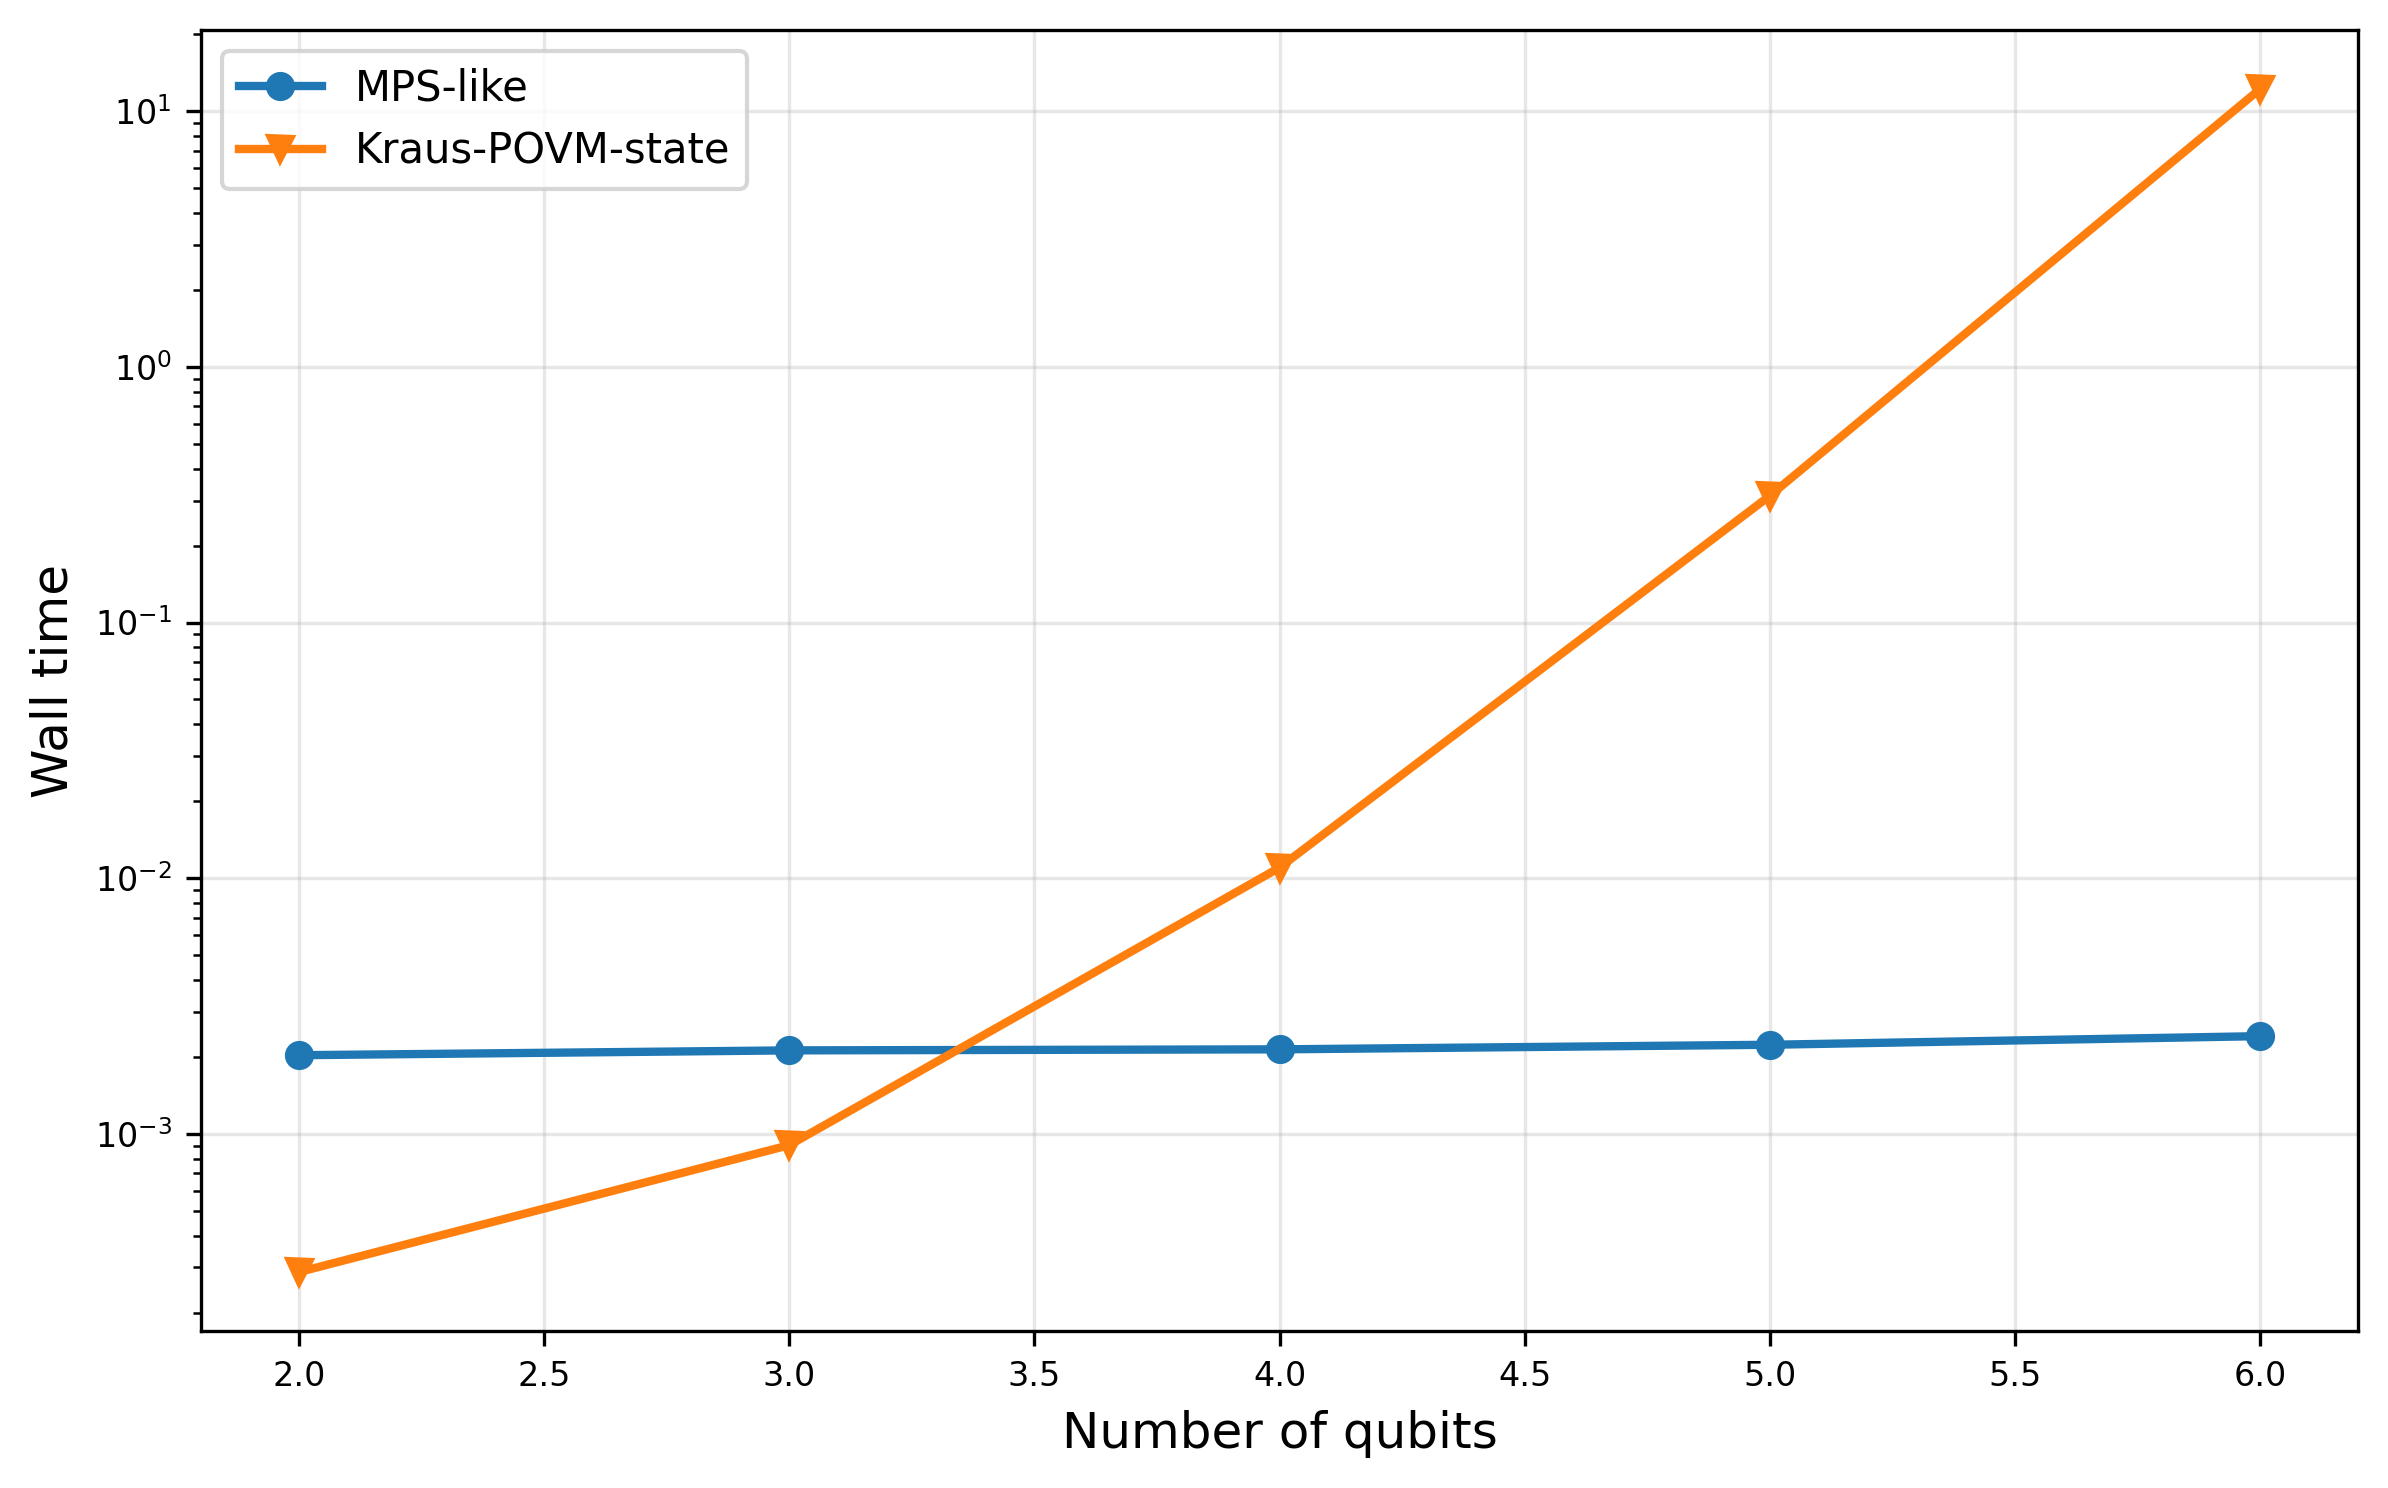

In [190]:
# Now plotting the things
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(8, 5), dpi=300)

times_naive = jnp.array([288e-6, 903e-6, 11e-3, 313e-3, 12.2])
times_mps = jnp.array([2.03, 2.12, 2.14, 2.23, 2.41])/1000

plt.semilogy(range(2, num_qubits+1), times_mps, label="MPS-like", color="#1f77b4", linestyle="-", marker="o", linewidth=2, markersize=6)
plt.semilogy(range(2, num_qubits+1), times_naive, label="Kraus-POVM-state", color="#ff7f0e", linestyle="-", marker="v", linewidth=2, markersize=6)


# Add labels, legend, and grid
plt.xlabel("Number of qubits", fontsize=12)
plt.ylabel("Wall time", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)

# Show the plot
plt.tight_layout()
plt.show()

In [6]:
key = jax.random.PRNGKey(42)

A = jax.random.uniform(key, [1000,1000])
B = jax.random.uniform(key, [1000,1000])

%timeit jnp.dot(A,B)

%timeit A.dot(B)

%timeit jnp.einsum("ij,jk",A,B)

%timeit A @ B

7.04 ms ± 59.7 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.02 ms ± 31 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.99 ms ± 13.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7 ms ± 23.9 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
import numpy as np
A = np.random.random([1000,1000])
B = np.random.random([1000,1000])

%timeit np.dot(A,B)

%timeit A.dot(B)

%timeit np.einsum("ij,jk",A,B)

%timeit A @ B

17.5 ms ± 1.44 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
18.1 ms ± 1.62 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
153 ms ± 6.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
16.7 ms ± 361 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
matrix_1 = np.random.random([3,4])
matrix_2 = np.random.random([4,5])

matrix_1 @ matrix_2

array([[0.7900092 , 1.01838305, 0.94787053, 0.82512841, 0.57482204],
       [1.33909362, 1.73355851, 1.46439781, 1.31868596, 0.97113692],
       [0.71194852, 1.04261973, 1.0514495 , 0.9602178 , 0.52558704]])

In [ ]:
# comparing: einsum vs reordering of legs-merging-matrix multiplication

In [22]:
def matrix_multiplication_of_tensor(T1, T2, dot:bool=False):
    """Matrix-like multiplication of two tensors

    Args:
        T1: assume is a tensor of dimensions (d1, d2, d3)
        T2: assume is a tensor of dimensions (d3, d4)
    """
    d1, d2, d3 = T1.shape
    matrix_T1 = jnp.reshape(T1, shape=(d1*d2, d3))
    if dot:
        return matrix_T1.dot(T2)
    return matrix_T1 @ T2

In [13]:
key = jax.random.PRNGKey(42)

T1 = jax.random.uniform(key, [100,200,500])
T2 = jax.random.uniform(key, [500,1000])

%timeit matrix_multiplication_of_tensor(T1, T2)

71.9 ms ± 284 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
%timeit matrix_multiplication_of_tensor(T1, T2, dot=True)

The slowest run took 6.18 times longer than the fastest. This could mean that an intermediate result is being cached.
40.5 μs ± 35 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
%timeit matrix_multiplication_of_tensor(T1, T2, dot=True)

74.7 ms ± 3.17 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
%timeit jnp.einsum("ijk,kl->ijl", T1, T2)

70.2 ms ± 524 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
w = jnp.arange(5, 9).reshape(2, 2)
x = jnp.arange(6).reshape(2, 3)
y = jnp.arange(-2, 4).reshape(3, 2)
z = jnp.array([[2, 4, 6], [3, 5, 7]])

%timeit jnp.einsum('ij,jk,kl,lm->im', w, x, y, z)

%timeit jnp.einsum(w, (0, 1), x, (1, 2), y, (2, 3), z, (3, 4))  # implicit, via indices

%timeit w @ x @ y @ z  # direct chain of matmuls

%timeit jnp.linalg.multi_dot([w, x, y, z])

142 μs ± 2.93 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
143 μs ± 272 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
12.3 μs ± 402 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
203 μs ± 1.32 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [17]:
def chain_contraction(w,x,y,z):
    t1 = jnp.einsum('ij,jk->ik',w,x)
    t2 = jnp.einsum('ik,kl->il', t1, y)
    return jnp.einsum('il,lm->im', t2, z)

%timeit chain_contraction(w,x,y,z)

187 μs ± 463 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
